In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sco
import mpt

In [3]:
df = pd.read_csv("data/close_adjusted_17.csv")

# Convert 'date' to datetime
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Set 'date' as index
df.set_index("date", inplace=True)

In [4]:
#Getting rid of missing values
df = df.ffill().bfill()

In [4]:
df

,CSCO.close,UAL.close,TROW.close,ISRG.close,PRGO.close,TPR.close,DVN.close,MRO.close,BA.close,VRTX.close,...,TSS.close,CRM.close,PGR.close,WAT.close,BWA.close,LRCX.close,NWL.close,UAA.close,BLK.close,PPL.close
date,,,,,,,,,,,,,,,,,,,,,
2006-01-04,12.4822,40.3514,22.5279,13.5622,12.6991,22.6417,48.0416,14.2195,50.6391,28.3100,...,19.89,8.9925,16.4971,37.83,12.7070,32.2894,13.8143,4.0809,71.5851,12.7212
2006-01-05,12.8319,40.3514,22.5094,13.3645,12.8243,22.9809,47.4447,14.1722,50.0414,29.4800,...,20.47,9.0150,16.6350,37.26,12.4629,32.8907,13.8660,4.6014,70.8115,12.4858
2006-01-06,13.1256,40.3514,22.6938,13.3411,12.9662,23.0570,48.4785,14.3465,49.3441,31.2800,...,20.32,9.9625,16.5298,37.35,12.1397,34.0498,13.7856,4.5807,72.3982,12.5488
2006-01-09,13.3283,40.3514,23.0010,13.7445,12.9913,23.9015,48.3765,14.6197,48.9314,33.0999,...,20.18,9.6325,16.8952,38.34,12.2002,34.3897,13.9406,4.6272,73.2374,12.6287
2006-01-10,13.2654,40.3514,22.9150,14.2489,13.2334,23.7285,48.4493,14.9509,49.1662,34.0400,...,20.48,9.5625,16.8568,38.96,12.1897,33.7797,13.7569,4.8429,73.5390,12.5656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-19,49.1300,47.5400,105.4471,313.6100,33.3725,42.7021,49.0047,23.0700,205.4900,341.7000,...,118.84,210.3600,135.0600,267.48,45.9820,587.2413,8.6210,7.3000,661.8330,26.8195
2023-05-22,48.8200,47.4100,105.6745,313.6200,33.0850,41.8878,49.1242,23.4300,205.9100,339.9700,...,118.84,210.2600,135.6300,267.81,47.4666,583.4617,8.8590,7.3900,666.4888,26.7897
2023-05-23,48.9100,47.8700,104.8635,301.4400,32.8173,41.6494,48.9151,23.6400,202.6000,333.5100,...,118.84,206.6400,133.3500,265.92,46.5599,571.9135,8.9483,7.3900,656.7007,26.5420


Markowitz optimization function

In [10]:
def markowitz_optimization(returns):
    def portfolio_performance(weights, mean_returns, cov_matrix):
        port_return = np.sum(mean_returns * weights)
        port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return port_return, port_volatility

    # Optimization function
    def minimize_volatility(weights, mean_returns, cov_matrix):
        return portfolio_performance(weights, mean_returns, cov_matrix)[1]

    # Compute mean & covariance
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    num_assets = len(mean_returns)

    # Constraints & bounds
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    initial_guess = num_assets * [1. / num_assets]

    # Optimize for minimum volatility
    optimized_result = sco.minimize(minimize_volatility, initial_guess,
                                    args=(mean_returns, cov_matrix),
                                    method='SLSQP', bounds=bounds, constraints=constraints)

    # Return results
    optimal_weights = optimized_result.x
    return optimal_weights


Before going into Rolling Markowitz, I want to store weights for every window_size(100) days in one array, for calculations to be faster(maybe).

In [6]:
#Keeping smaller, 1 year data
smaller_df = df.iloc[:10]

#Returns dataframe
returns = ((smaller_df - smaller_df.shift(1)) / smaller_df.shift(1)).iloc[1:]

In [9]:
mpt.markowitz_optimization(returns).shape

(505,)

In [26]:
def optimal_weights_per_window_size_days(returns, window_size = 100):
    optimal_weights_per_window_size_days = []
    for t in range(window_size, len(returns)):
        returns_window = returns.iloc[t-window_size:t]
        optimal_weights = markowitz_optimization(returns_window)
        optimal_weights_per_window_size_days.append(optimal_weights)
    return np.array(optimal_weights_per_window_size_days)

In [27]:
optimal_weights_per_100_days = optimal_weights_per_window_size_days(returns)

KeyboardInterrupt: 

In [24]:
optimal_weights_per_100_days.shape

(0,)

Rolling Markowitz Optimization

[1]


ValueError: x and y must have same first dimension, but have shapes (0,) and (1,)

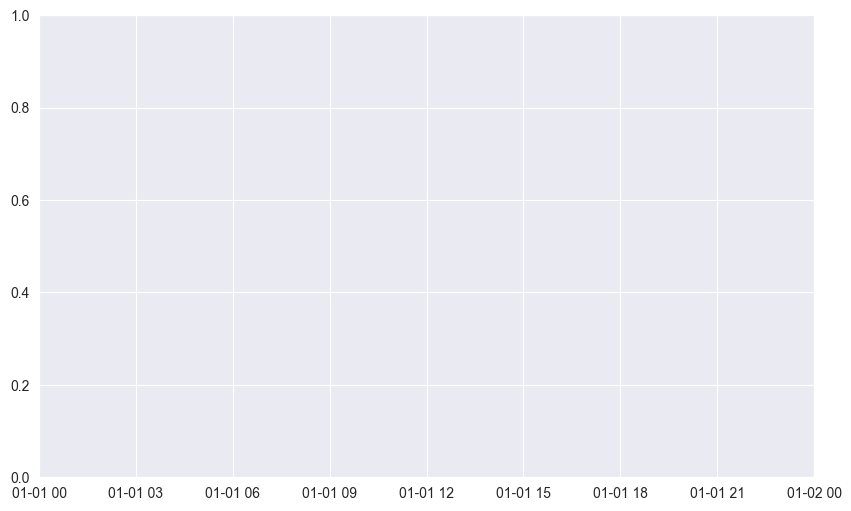

In [18]:
# Portfolio value tracking
portfolio_value = [1]  # Start with 1

# Rolling window Markowitz portfolio simulation
window_size = 100  # Use past 100 days of returns

for t in range(window_size, len(returns)):
    # Get Markowitz optimal weights from our weight array
    optimal_weights = optimal_weights_per_100_days[t - window_size]

    # Compute portfolio return on day 101
    next_day_return = np.dot(optimal_weights, returns.iloc[t])

    # print(f"Weights: {optimal_weights}")
    # print(f"Day {t} return: {next_day_return}")

    # Update portfolio value
    portfolio_value.append(portfolio_value[-1] * (1 + next_day_return))

# Convert to numpy array for easier plotting
portfolio_value = np.array(portfolio_value)

print(portfolio_value)
# Plot portfolio growth
plt.figure(figsize=(10, 6))
plt.plot(returns.index[99:], portfolio_value, label='Portfolio Growth', color='blue')
plt.title("Portfolio Growth Over Time Using Rolling Markowitz Optimization 0-365")
plt.xlabel("Days")
plt.ylabel("Portfolio Value")
# plt.ylim(0.9999, 1.000001)
plt.legend()
plt.grid(True)
plt.show()
